## Run this notebook on colab or your local system
<a href="https://drive.google.com/file/d/1hTglAeHEqg8Z2xtNfzLAnINc3ImJ3ayP/view?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

In [ ]:
##don't run this line if you are using your local machine
#!pip install neurodiffeq > /dev/null 2> /dev/null

In [43]:
#import all helper functions
from helper import *

#import all required packages
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import time
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# One-Shot TL to Solve Linear ODEs
__Wanzhou Lei__

We are interested in solving the following second order linear ODEs:

$$
\frac{d^2x}{dt^2} + \delta \frac{dx}{dt} + \alpha x = f(t) = \gamma cos(\omega t)
$$

where $\delta, \alpha, \gamma, \omega$ are parameters of the ODE. The forcing function can be changed into other form. But for simnplicity, let's fix it to this form now. In order for this second-order linear ODE to have unique solution, we have initial value $x_0$ and initial velocity $\dot{x_0}$ fixed.

In order for One-Shot TL to work for this second order linear ODE, we have to first transform this 1D second order linear ODE into a system of first order linear ODE systems by introducting a new variable $y$. Suppose $y = \frac{dx}{dt}$, the above ODE is equivalent to:

$$
\begin{cases}
\frac{dx}{dt} = y \\
\frac{dy}{dt} + \delta y + \alpha x = \gamma cos(\omega t) = f(t)
\end{cases}
$$

With initial conditions $x_0$ and $y_0 = \dot{x_0}$. Let the vector $\mathbf{u}(t) = [x(t), y(t)]^T$, the above system of ODEs can be vectorized into:

$$
\dot{\mathbf{u}} + A\mathbf{u} = F = \begin{bmatrix}
0 \\ f
\end{bmatrix}
$$

where $A = \begin{bmatrix} 0 & -1 \\ \alpha & \delta \end{bmatrix}$, with initial condition: $\mathbf{u}(0) = [x_0, \dot{x_0}]^T := \mathbf{u}^{(0)}$

## Step 1. Multiheaded Neural Network
The first step to do TL on this class of ODE is to build a multiheaded neural network to solve k ODE systems of this form simultaneously in order to learn a meaning representation of the hidden solution space. The network approximates the k ODE systems solutions $\mathbf{u}_i: [0, 5] \rightarrow \mathbb{R^2}$.

The neural network contains 2 parts. In the first part, 1D input goes through 4 hidden layers of shape 128, 128, 256, 512 respectively connected by custom activation function. The 512 dimensional activation of the last hidden layer can be seen as the flattened hidden state matrix $H \in \mathbb{R}^{2 \times 256}$. In the second part, k linear layers are applied to each row of the hidden state matrix H, producing k 2D output.

The class Multihead defines such custom multiheaded neural network. The user can specify the number of heads, the activation function used to connect hidden layers and the data type used to store the parameters. Fill in the code of the class "Multihead" to make the Multihead model work as desired. 

In [44]:
class Multihead(nn.Module):
  def __init__(self, k, act = nn.Tanh(), dtype=torch.float32):
    super().__init__()
    self.act = act
    self.linear1 = nn.Linear(1, 128, dtype=dtype)
    self.linear2 = nn.Linear(128, 128, dtype=dtype)
    self.linear3 = nn.Linear(128, 256, dtype=dtype)
    self.linear4 = nn.Linear(256, 512, dtype=dtype)

    ##define k final layers with bias
    self.final_layers = nn.ModuleList(
        [nn.Linear(256, 1, bias=True, dtype=dtype) for _ in range(k)] 
    )
    self.k = k

  #it returns the output of the network and the hidden state
  def forward(self, x):
    out = self.act(self.linear1(x))
    out = self.act(self.linear2(out))
    out = self.act(self.linear3(out))
    out = self.act(self.linear4(out))
    out1 = out[:, :256]
    out2 = out[:, 256:]
    output = []
    for i in range(self.k):
      first = self.final_layers[i](out1)
      second = self.final_layers[i](out2)
      concat = torch.cat((first, second), axis=1)
      output.append(concat)
    #returns output of shape (k, B, 2), hidden states of shape (B, 512)
    return torch.stack(output), out

Now, define a 10-headed neural network connected by silu activation function. 

In [45]:
##construct a model of 10 heads
k=10
model = Multihead(k=k, act = nn.functional.silu)
model

Multihead(
  (linear1): Linear(in_features=1, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-9): 10 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [79]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

182661

## Step 2. Loss Function
The next step is to define a loss function used to train the multi-headed neural network to solve k instances of ODE systems simultaneously. To compute the loss, we first sample the interior of the time domain and get n sample time points. In each loss evaluation, we sample n points in the domain and use them to compute the loss. Let's denote $T$ as the set of sample time points and $||T|| = n$. Then the loss for the ith head is defined as:

$$
L^{(i)} = \alpha_1 L_{ODE}^{(i)} + \alpha_2 L_{IC}^{(i)}
$$

Where the ODE loss for the ith head is:

$$
L_{ODE}^{(i)} = \frac{1}{2n} \sum_{t \in T} \left ( \dot{\mathbf{u}}_i(t) + A\mathbf{u}_i(t) - F_i(t) \right )^2
$$

and the initial condition loss for the ith head is:

$$
L_{IC}^{(i)} = \frac{1}{2} \left ( \mathbf{u}_i(0) - \mathbf{u}_i^{(0)} \right)^2
$$

The loss for the ith head is the combination of the ODE loss of the ith head and the initial condition loss of the ith head, where $\alpha_1, \alpha_2$ are the ODE weight and IC weight respectively. They determine how much attention we put into each category of loss. For normalization purpuse, we require that $\alpha_1 + \alpha_2 = 2$. $u_i^{(0)}$ is the initial conditions for the ith head. The total loss is defined as the average loss over all k heads:

$$
L_{total} = \frac{1}{k} \sum_{i=1}^k L^{(i)}
$$


The function below implements the aforementioned total loss. In its arguments, **forcing** is a list of function handlers of the forcing functions of the k ODEs. **delta_list, alpha_list, initial_values, initial_velocities** are all lists of parameters for the k ODEs to solve. **domain** is the time interval we are interested in, we fix it at (0, 5). **sample_size** is the aforementioned n, the size of sample time points. **alpha_ode, alpha_ic** are the weights mentioned before. The loss function returns a dictionary of total loss, ODE loss and initial condition loss. 

In [46]:
##this function computes the loss of a multiheaded neural network
def loss(model, forcing, delta_list, alpha_list, initial_values, initial_velocities, domain=(0, 5),
         sample_size=100, epsilon=1e-3, dtype=torch.float32,
         alpha_ode = 1, alpha_ic = 1):
  ##generate samples of time points
  t_samples = (domain[1]-domain[0])*Generator1D(size=sample_size, method='equally-spaced-noisy').get_examples() + domain[0]
  ##prune these samples into the domain
  t_samples[t_samples < domain[0]] = domain[0] + epsilon
  t_samples[t_samples > domain[1]] = domain[1] - epsilon
  ##change data type to single precition (we don't need high accuracy when training)
  t_samples = t_samples.to(dtype)
  t_samples = t_samples.view(-1, 1)
  ##require gradients
  t_samples = t_samples.requires_grad_() #shape (sample_size, 1)

  ##evaluate the model at these sample points
  output, _ = model(t_samples) #shape (k, sample_size, 2)
  x = output[:,:,0] #shape (k, sample_size)
  y = output[:,:,1] #shape (k, sample_size)
  #compute the derivatives
  dxdt = torch.cat([diff(x[i].view(-1, 1), t_samples) for i in range(x.shape[0])], dim=1) #shape (sample_size, k) dx/dt
  dydt = torch.cat([diff(y[i].view(-1, 1), t_samples) for i in range(y.shape[0])], dim=1) #shape (sample_size, k) dy/dt

  ##compute the ODE loss
  ##first compute the forcing function values accross the k heads
  force = torch.cat([forcing[i](t_samples) for i in range(len(forcing))], dim=1) #(sample_size, k)
  force = force.to(dtype)
  ##compute the ODE residual
  alpha_list = torch.tensor(alpha_list, dtype=dtype)
  delta_list = torch.tensor(delta_list, dtype=dtype)
  alpha_x = (alpha_list.view(-1, 1)*x).T #shape (sample_size, k)
  delta_dxdt = delta_list * dxdt #shape (sample_size, k)
  delta_y = (delta_list.view(-1, 1)*y).T
  residual = torch.cat(
          [
              (dxdt - y.T).unsqueeze(2),
              (dydt + delta_y + alpha_x - force).unsqueeze(2),
          ],
          dim=2
      ) #shape (sample_size, k, 2)
  ode_loss = F.mse_loss(residual, torch.zeros_like(residual))

  #compute the initial condition loss
  #compute the model's initial values
  output0, _ = model(torch.tensor([[domain[0]]], dtype=dtype)) #shape (k, 1, 2)
  u0 = torch.stack([torch.tensor(initial_values, dtype=dtype),
           torch.tensor(initial_velocities, dtype=dtype)], dim=1).view(-1, 1, 2)
  ic_loss = F.mse_loss(u0, output0)

  #compute the total loss
  total_loss = alpha_ode * ode_loss + alpha_ic * ic_loss

  return {'total_loss': total_loss, 'ode_loss': ode_loss, 'ic_loss': ic_loss}

## Step 3. Model Training

Before real trainning, we need to fix the 10 ODE systems to learn. The purpose of training the network is not to find solutions to these 10 ODE systems but rather to learn a meaningful hidden state representation of the solution space of this form of ODE system. Therefore, we want to sample the ODE space 10 sample points as the 10 heads to learn. 

$$
\dot{\mathbf{u}} + A\mathbf{u} = F = \begin{bmatrix}
0 \\ \gamma cos(\omega t)
\end{bmatrix}
$$

where $A = \begin{bmatrix} 0 & -1 \\ \alpha & \delta \end{bmatrix}$, with initial condition: $\mathbf{u}(0) = [x_0, \dot{x_0}]^T := \mathbf{u}^{(0)}$
The ODE space is parametrized by the following parameters: $\gamma, \omega, \alpha, \delta, x_0, \dot{x}_0$. So, we decide to uniformly sample k of each of these parameters and use them to construct a group of sample ODE syste. The parameter sample spaceswe used are:

$$
\gamma \in [0.5, 3]; \omega \in [0.5, 3]; \alpha \in [0.5, 4.5]; \delta \in [0.5, 4.5]; x_0 \in [-3, 3]; \dot{x}_0 \in [-1, 1]
$$

In [47]:
k=10; random_seed = 42
para_dict = generate_parameters(k, seed=random_seed)
para_dict

{'gamma_list': array([1.4363503 , 2.87678577, 2.32998485, 1.99664621, 0.8900466 ,
        0.8899863 , 0.64520903, 2.66544036, 2.00278753, 2.27018144]),
 'omega_list': array([0.55146124, 2.92477463, 2.5811066 , 1.03084778, 0.95456242,
        0.95851127, 1.26060561, 1.81189108, 1.57986255, 1.22807285]),
 'alpha_list': array([2.94741158, 1.05797544, 1.66857859, 1.96544737, 2.32427994,
        3.64070385, 1.29869513, 2.55693775, 2.86965828, 0.68580165]),
 'delta_list': array([2.93017941, 1.18209649, 0.76020637, 4.29554215, 4.36252813,
        3.73358939, 1.71845508, 0.89068846, 3.23693211, 2.26060997]),
 'initial_values': array([-2.26777059, -0.02893854, -2.79366887,  2.45592241, -1.44732011,
         0.97513371, -1.12973354,  0.12040813,  0.28026168, -1.89087327]),
 'initial_velocities': array([ 0.93916926,  0.55026565,  0.87899788,  0.7896547 ,  0.19579996,
         0.84374847, -0.823015  , -0.60803428, -0.90954542, -0.34933934]),
 'Forcing_functions': [<function helper.forcing_decorato

Use the below configuration to train a 10-headed neural network. You can just go ahead running the following 3 plots. The training may take 1-10 mins to finish, depending on your local machine performance. 

In [48]:
#specify the training configuration
##define the domain, sample size and forcing functions
domain = (0, 5)
sample_size = 50
epsilon = 1e-4
dtype = torch.float32

#weights
alpha_ode = 0.5; alpha_ic = 1.5

##define the optimizer
learning_rate = 4e-4
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

##define the exponential learning rate decay scheduler
gamma = 0.92; step_size = 100
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

##define number of iterations to take
num_iter = 3000
every=100

In [49]:
loss_trace, ode_loss_trace, ic_loss_trace = train(model, optimizer, loss, num_iter, para_dict, sample_size=sample_size, 
        domain=domain, every=every, ode_weight=alpha_ode, ic_weight=alpha_ic, scheduler=scheduler, epsilon=epsilon, dtype=dtype)

  0%|          | 0/3000 [00:00<?, ?it/s]

100th Iter: total 0.4158115088939667, ode 0.7917706370353699, ic 0.013284124433994293
200th Iter: total 0.13786673545837402, ode 0.27549925446510315, ic 7.807243673596531e-05
300th Iter: total 0.05833808332681656, ode 0.1165400892496109, ic 4.5359985961113125e-05
400th Iter: total 0.027356771752238274, ode 0.054694030433893204, ic 6.503750228148419e-06
500th Iter: total 0.009016293101012707, ode 0.0180270466953516, ic 1.8466760138835525e-06
600th Iter: total 0.0031964974477887154, ode 0.00638975715264678, ic 1.079303842743684e-06
700th Iter: total 0.0016542649827897549, ode 0.0033054929226636887, ic 1.0123648053195211e-06
800th Iter: total 0.0012563291238620877, ode 0.0025098989717662334, ic 9.197499934998632e-07
900th Iter: total 0.0009852792136371136, ode 0.001969619421288371, ic 3.130070354018244e-07
1000th Iter: total 0.000633692485280335, ode 0.0012664691312238574, ic 3.0529741934515187e-07
1100th Iter: total 0.0005308936233632267, ode 0.001061149756424129, ic 2.1251257464882656e-

<Figure size 3200x2400 with 0 Axes>

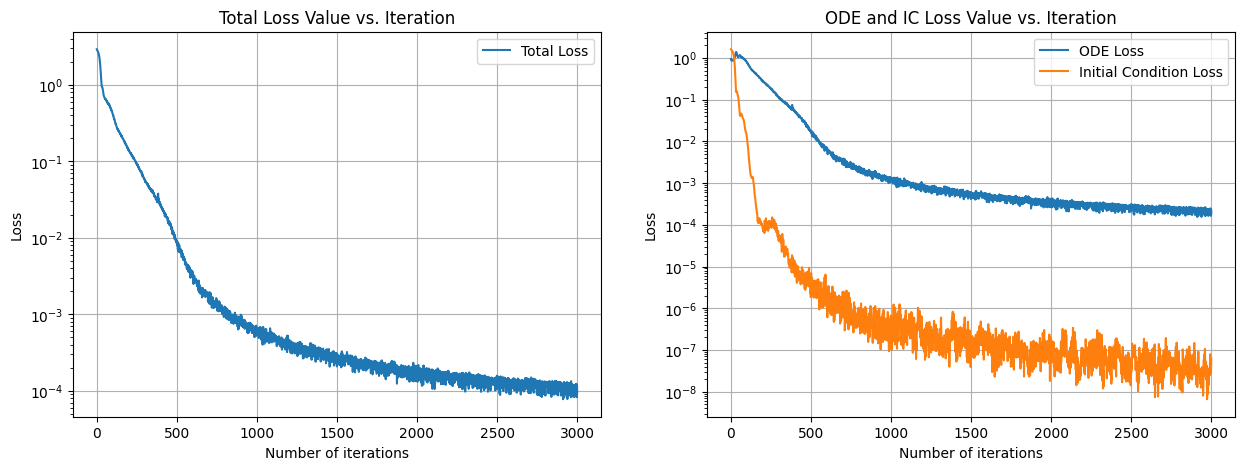

In [50]:
plt.figure(dpi=500);
plot_trace(loss_trace, ode_loss_trace, ic_loss_trace)

In [9]:
# uncomment and run this segment of code if you want to load a pretrained model
# import pickle
# file = open('ODE_multiheaded_model.pickle', 'rb')
# model = pickle.load(file)

In the code segment below, we compute the numerical solutions of these 10 ODE systems using Explicit Runge-Kutta method of order 8.

In [51]:
k=10
domain = (0, 5)
t_eval = np.linspace(domain[0], domain[1], 100)
##construct a list of RHS functions
RHS_functions = [RHS_decorator(para_dict['gamma_list'][i], para_dict['omega_list'][i],
                               para_dict['alpha_list'][i], para_dict['delta_list'][i]) for i in range(k)]

numerical_result = [solve_ivp(RHS_functions[i], domain,
                    np.array([para_dict['initial_values'][i], para_dict['initial_velocities'][i]]),
                          t_eval=t_eval, method = 'DOP853') for i in range(k)]

We also compute the network solution of these 10 ODE systems.

In [52]:
#compute model solutions on k heads
t_points = np.linspace(domain[0], domain[1], 100)
t_grids = torch.tensor(t_points, dtype=dtype).reshape(-1, 1)
t_grids.requires_grad_()
output, H = model(t_grids) #shape (k, 50, 2)

### Plot the neural network and numerical solution over the 10 ODE systems
Each of the below 10 subplots displays the neural network solution and the numerical solutions of the 10 ODE systems. You can see that the Neural Network Approximates the numerical solution very well. The model's and numerical solutions coincide with each other. Hopefully, the model already learnt something meaningful about the hidden state, which can be used in transfer learing.

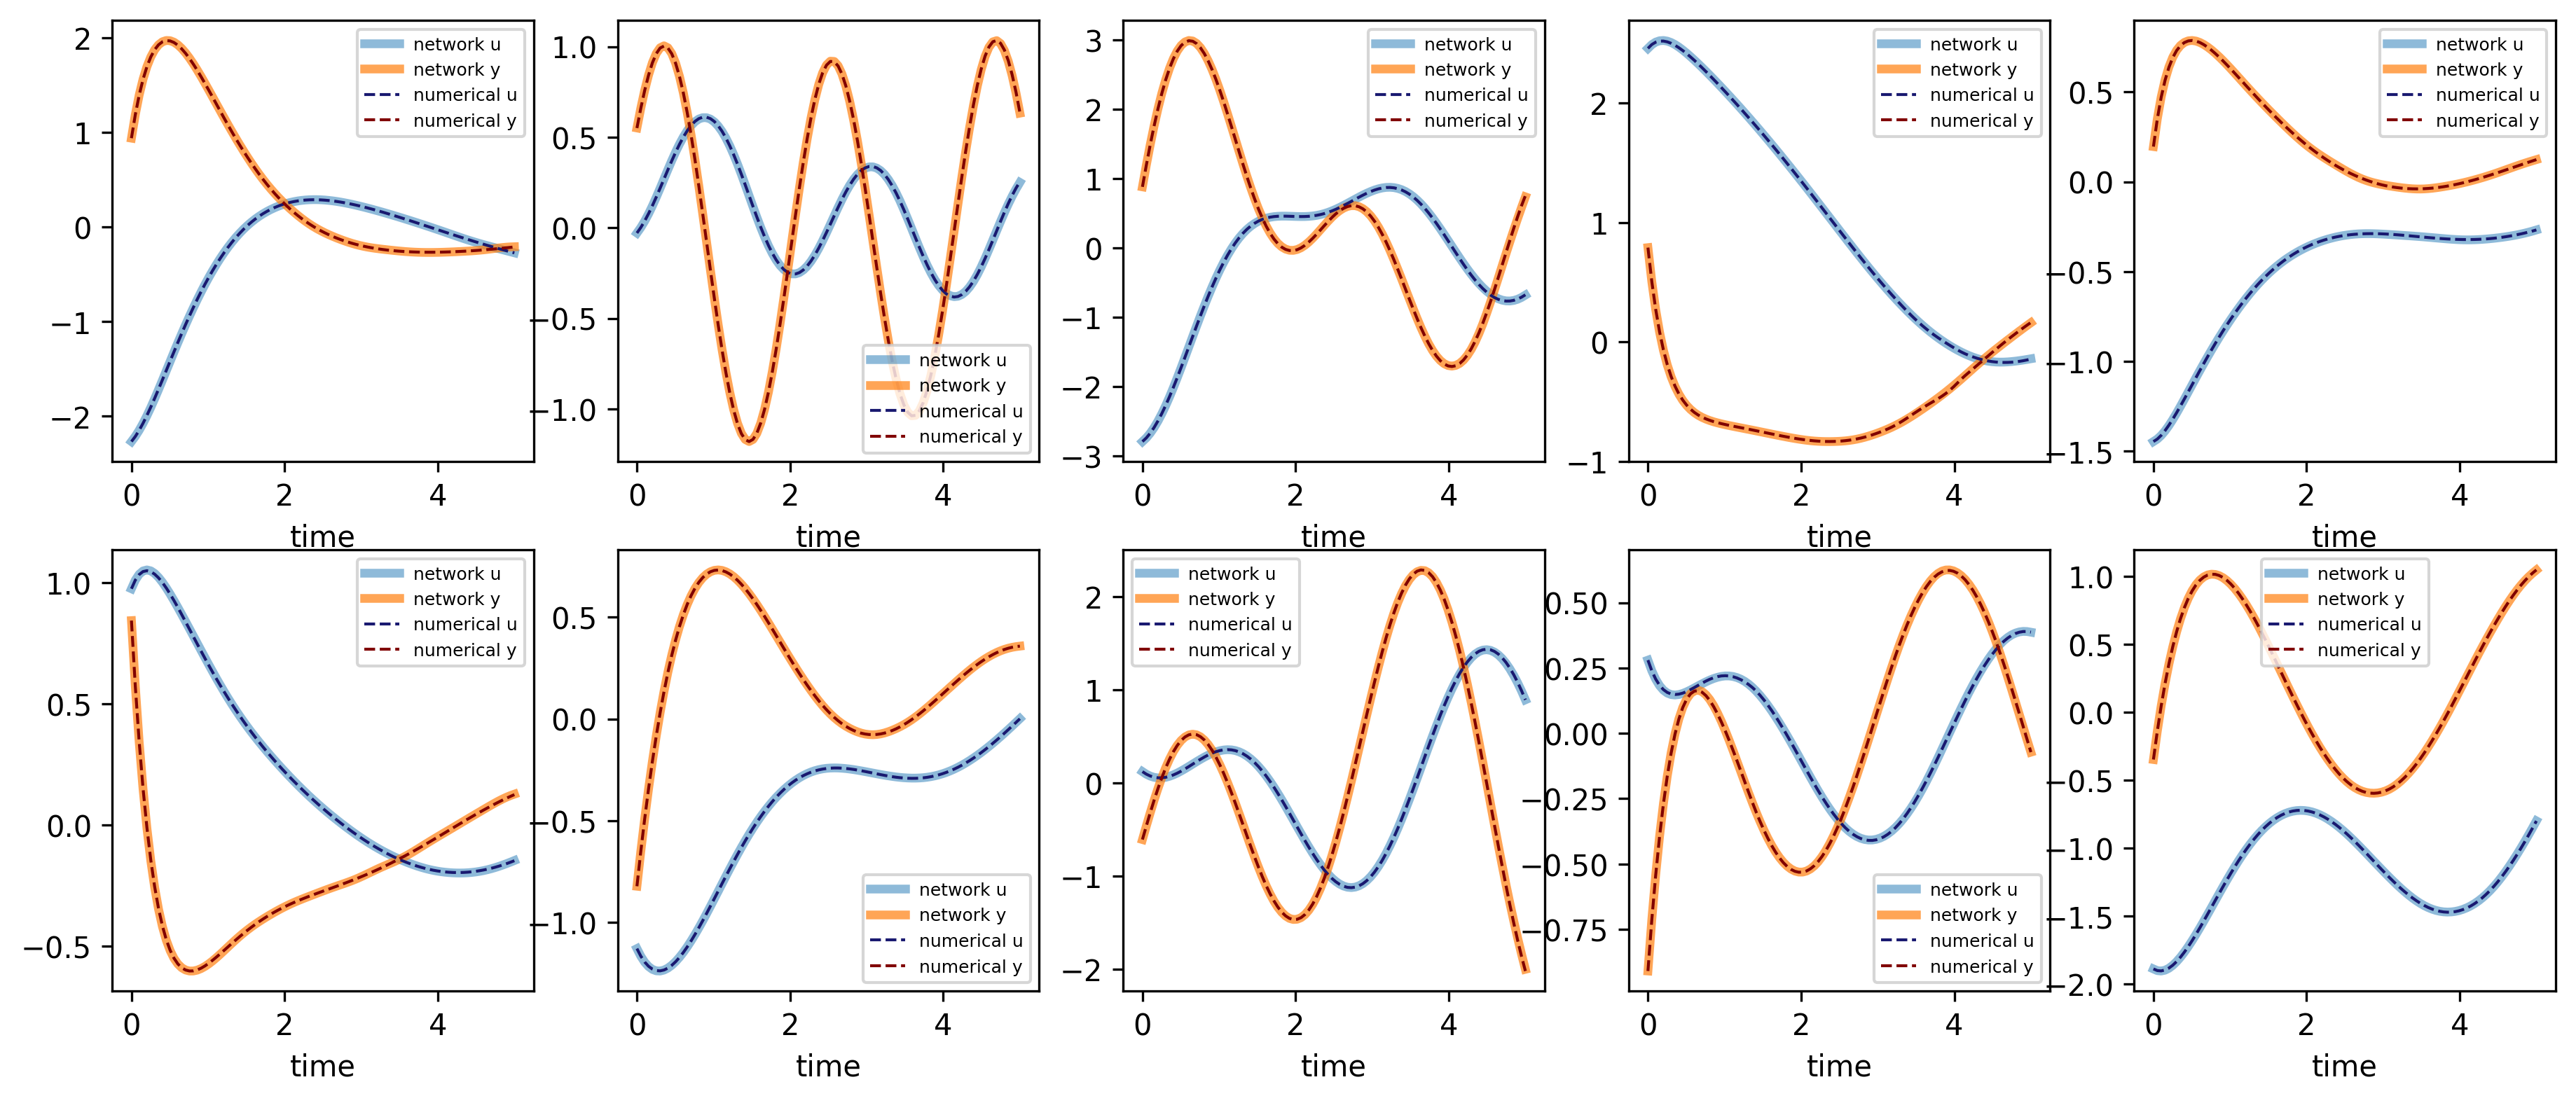

In [53]:
#compute numerical solutions on k heads
fig, ax = plt.subplots(2, 5, figsize=(15, 6), dpi=300);
for i in range(10):
  j = i//5; k = i%5
  x = output[i, :, 0].detach().numpy()
  y = output[i, :, 1].detach().numpy()
  ax[j][k].plot(t_points, x, lw=3, alpha = 0.5,  label='network u');
  ax[j][k].plot(t_points, y, lw=3, alpha = 0.7, label='network y');
  ax[j][k].set_xlabel('time');
  ax[j][k].plot(numerical_result[i].t, numerical_result[i].y[0], '--', c='midnightblue', lw=1, label='numerical u');
  ax[j][k].plot(numerical_result[i].t, numerical_result[i].y[1], '--', c='maroon', lw=1, label='numerical y');
  ax[j][k].legend(fontsize=6);

In [54]:
print("The MSE btw NN sol and numerical sol is: ", compute_MSE(output, numerical_result))

The MSE btw NN sol and numerical sol is:  8.468076918252652e-06


## Step 4. One-Shot Transfer Leanning

Now that we have trained the network, we want to solve a new ODE system of the following form in one shot:

$$
\dot{\mathbf{u}} + A\mathbf{u} = F = \begin{bmatrix}
0 \\ f
\end{bmatrix}
$$

where $A = \begin{bmatrix} 0 & -1 \\ \alpha & \delta \end{bmatrix}$, with initial condition: $\mathbf{u}(0) = [x_0, \dot{x_0}]^T := \mathbf{u}^{(0)}$, the forcing functon f can be arbitrary.

The code segment below is only for precomputing the hidden state and its derivative.

In [55]:
##this compute the second derivative
def compute_Htt(H, t):
    output = []
    for i in range(H.shape[1]):
      output.append(diff(H[:,i].reshape(-1, 1), t, order=2).detach().numpy())
    return np.concatenate(output, axis=1)

In [56]:
#this code is just for precomputing the hidden state H and its derivative 

##compute H and Ht
t_points = np.linspace(domain[0], domain[1], 100)
t_grids = torch.tensor(t_points, dtype=dtype).reshape(-1, 1)
t_grids.requires_grad_()
output, H = model(t_grids) #shape (k, 50, 2)

Ht = compute_Ht(H, t_grids) #numpy of shape (N, 512)
Htt = compute_Htt(H, t_grids)
##reshape Ht to shape (2N, 257) add column of 0
Ht = np.hstack((Ht.reshape(2*Ht.shape[0], -1), np.zeros((2*Ht.shape[0], 1))))
Htt = np.hstack((Htt.reshape(2*Htt.shape[0], -1), np.zeros((2*Htt.shape[0], 1))))

##reshape H into a numpy array of shape (2N, 257) add column of 1
H = H.detach().numpy()
H = np.hstack((H.reshape(2*H.shape[0], -1), np.ones((2*H.shape[0], 1))))

#compute H0
_, H0 = model(torch.tensor([[0]], dtype=dtype))
H0 = np.hstack([H0.reshape(2, -1).detach().numpy(), np.ones((2*H0.shape[0], 1))]) #shape (2, 257)

We generate 20 unseen linear ODE systems to solve using one-shot TL introduced during the lecture. You can change the seed number to produced diferent results.

In [57]:
##generate 20 unseen linear ODE systems to solve using one-shot TL
num = 20
seed = 46
new_para = generate_parameters(num, seed=seed)

__One_Shot_solve(f, H, Ht, H0, alpha, delta, initial_value, initial_velocity, t_grids)__
* f: the function R --> R handler of the forcing function
* H, Ht, H0 matrices computed to use to compute the M and Minv matrices (these matrices are pre-computed and available to use)
* alpha, delta the parameter values of the new linear ODE system
* initial_value, initial_velocity, the initial value and velovity of the new system
* t_grids is just the tensor you want to evaluate the solution at. 

This function returns a dictionary that contains the solution as well as all other information of the new equation. 

In [58]:
TL_sol = []; numerical_sol = []
##TL solve
s = time.time()
for i in tqdm(range(num)):
  #initial position and velocity
  initial_value = new_para['initial_values'][i]; initial_velocity = new_para['initial_velocities'][i]
  alpha = new_para['alpha_list'][i]; delta= new_para['delta_list'][i]
  #define new forcing functions
  f = new_para['Forcing_functions'][i]
  result = One_Shot_solve(f, H, Ht, H0, alpha, delta, initial_value, initial_velocity, t_grids)
  TL_sol.append(result)
e = time.time()
print("One-Shot TL takes about {} seconds per solve".format((e-s)/num))

#numerical solve
s = time.time()
for i in tqdm(range(num)):
  #initial position and velocity
  initial_value = new_para['initial_values'][i]; initial_velocity = new_para['initial_velocities'][i]
  alpha = new_para['alpha_list'][i]; delta= new_para['delta_list'][i]
  gamma = new_para['gamma_list'][i]; omega = new_para['omega_list'][i]
  numerical_result = solve_ivp(RHS_decorator(gamma, omega, alpha, delta), domain, np.array([initial_value, initial_velocity]),
                             t_eval=np.linspace(0, 5, 100), method = 'DOP853')
  numerical_sol.append(numerical_result)
e = time.time()
print("Numerical Method takes about {} seconds per solve".format((e-s)/num))

  0%|          | 0/20 [00:00<?, ?it/s]

One-Shot TL takes about 0.01797064542770386 seconds per solve


  0%|          | 0/20 [00:00<?, ?it/s]

Numerical Method takes about 0.0025404930114746095 seconds per solve


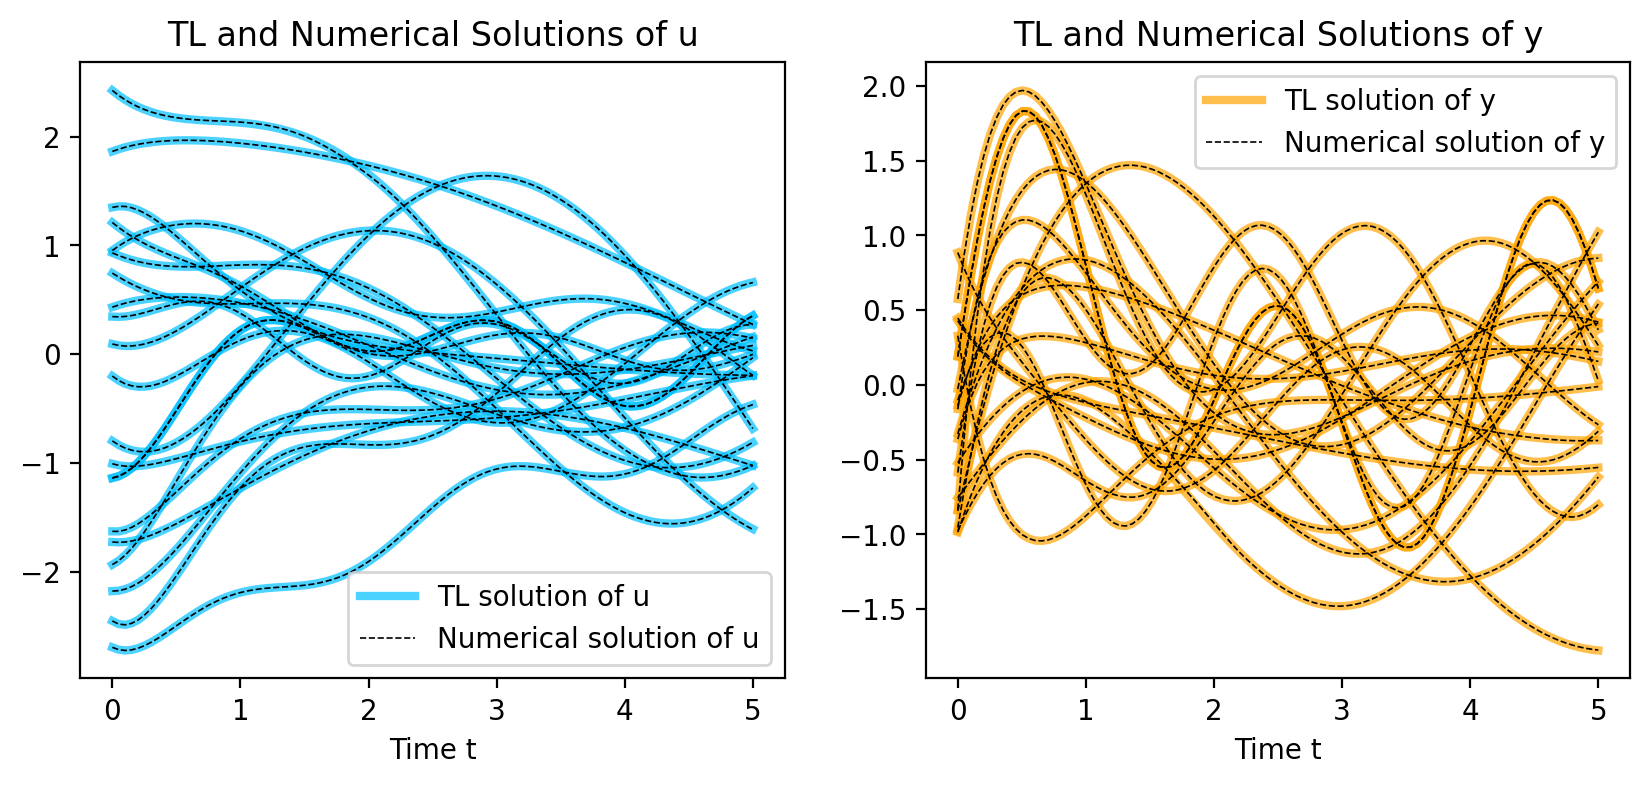

In [59]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), dpi=200);
for result in TL_sol:
  ax[0].plot(t_points, result['x'], c='deepskyblue', lw=3, alpha=0.7);
  ax[1].plot(t_points, result['y'], c='orange', lw=3, alpha=0.7);
ax[0].plot(t_points, TL_sol[-1]['x'], c='deepskyblue', lw=3, alpha=0.7, label='TL solution of u');
ax[1].plot(t_points, TL_sol[-1]['y'], c='orange', lw=3, alpha=0.7, label='TL solution of y');
for result in numerical_sol:
  ax[0].plot(result.t, result.y[0], '--', c='black', lw=0.6)
  ax[1].plot(result.t, result.y[1], '--', c='black', lw=0.6)
ax[0].plot(numerical_sol[-1].t, numerical_sol[-1].y[0], '--', c='black', lw=0.6, label='Numerical solution of u')
ax[1].plot(numerical_sol[-1].t, numerical_sol[-1].y[1], '--', c='black', lw=0.6, label='Numerical solution of y')
ax[0].set_xlabel("Time t");
ax[1].set_xlabel("Time t");
ax[0].set_title("TL and Numerical Solutions of u");
ax[1].set_title("TL and Numerical Solutions of y");
ax[0].legend(); ax[1].legend();

In [60]:
##compute the MSE btw numerical and TL solutions
MSE = ((np.array([sol['x'] for sol in TL_sol]) - np.array([sol['y'][0] for sol in numerical_sol]))**2).mean()
print("The Average MSE between the TL solution and numerical solution is: ", MSE)

The Average MSE between the TL solution and numerical solution is:  1.3523327453261209e-06


## Step 5.  Perturbation Method to Solve Duffing Equations

In [61]:
##generate 20 unseen non ODE systems to solve using p-shot TL
num = 20
seed = 2
new_para = generate_parameters(num, seed=seed, gamma_domain = (0.7, 2.8), omega_domain = (0.7, 2.8), alpha_domain = (0.7, 4.3), 
            delta_domain = (0.7, 4.3), initial_domain = (-2.7, 2.7), velocity_domain = (-0.9, 0.9))

##define the points we want to evaluate the solution at
t_points = np.linspace(domain[0], domain[1], 100)
t_grids = torch.tensor(t_points, dtype=dtype).reshape(-1, 1)
t_grids = t_grids.requires_grad_()

As is mentioned in lecture, the solution of Duffing equation of the following form: 

$$
\frac{d^2 x}{dt^2} + \delta \frac{dx}{dt} + \alpha x + \beta x^3 = \gamma cos(\omega t)
$$

can be approximated as a sum of the solutions of p+1 first order linear ODE system:

$$
\dot{\mathbf{u}} + A\mathbf{u} = F = \begin{bmatrix}
0 \\ f
\end{bmatrix}
$$

which is exactly the linear ODE system we trained the network to learn to solve. So, we can use this multihead PINN to solve Duffing equation by perturbation method.

We aim to solve 30 unseen Duffing equations with fixed $\beta = 0.5$.

Loop through the 30 parameter sets for Duffing equation defined in an earlier cell, compute the solution of each of the 30 Duffing equation using the __p_shot_solve__ function. The result should be a dictionary that contains all solutions and other information. Append this dictionay to the result_dict list. The function has the following signature: 

__p_shot_solve(f0_values, beta, alpha, delta, initial_value, initial_velocity, H, Ht, H0, indices_list, p=12)__
* f0_values: a tensor of the values of the forcing function at the grid points we are interested in.
* beta, alpha, delta,: the parameters $\beta$, $\alpha$, $\delta$ of Duffing equation.
* initial_value, initial_velocity: the initial value and velovity of the Duffing equation
* H, Ht, H0: H, Ht, H0 matrices computed to use to compute the M and Minv matrices (these matrices are pre-computed and available to use)
* indices_list: a utility list used to iteratively determine the forcing function. You can just directly use __indices_list__.
* p, default 12, the number of terms used to approximate the solution.

Use beta = 0.5 and p = 12. Compute the solution and plot the solution together with the numerical solution. Compute the report the average MSE between them. After finishing this, do the following experiment: instead of using beta=0.5, change beta to 0.8 and run the code.

In [62]:
#fixing beta to 0.5
beta = 0.5; p = 21
indices_list = []
for i in range(p):
    indices = find_three_integers(i)
    indices_list.append(indices)
    
result_dict = []
duffing_loss_list = []
s = time.time()
for i in tqdm(range(num)):
    f0_values = new_para['Forcing_functions'][i](t_grids).detach().numpy()
    dict = p_shot_solve(f0_values, beta, new_para['alpha_list'][i], new_para['delta_list'][i], 
                 new_para['initial_values'][i], new_para['initial_velocities'][i], H, Ht, H0, indices_list, p=p)
    result_dict.append(dict)
    duffing_dict = compute_duffing_loss(H, Ht, Htt, H0, dict['W'], new_para['delta_list'][i], 
                new_para['alpha_list'][i], beta, f0_values, new_para['initial_values'][i], new_para['initial_velocities'][i])
    duffing_loss_list.append(duffing_dict)
e = time.time()
print("Speed: {} seconds per solve.".format((e-s)/num))
mean_duffing_loss = np.mean([ele['total_loss'] for ele in duffing_loss_list])
print(mean_duffing_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.018147504329681395 seconds per solve.
3.4633825282394608e-06


In [63]:
##compute numerical solutions
numerical_duffings = []
for i in tqdm(range(num)):
    gamma = new_para['gamma_list'][i]; omega = new_para['omega_list'][i]
    f = lambda t: gamma*np.cos(omega * t)
    result = solve_duffing(new_para['delta_list'][i], new_para['alpha_list'][i], beta, f, 
            np.array([new_para['initial_values'][i], new_para['initial_velocities'][i]]), domain, t_points)
    numerical_duffings.append(result)

  0%|          | 0/20 [00:00<?, ?it/s]

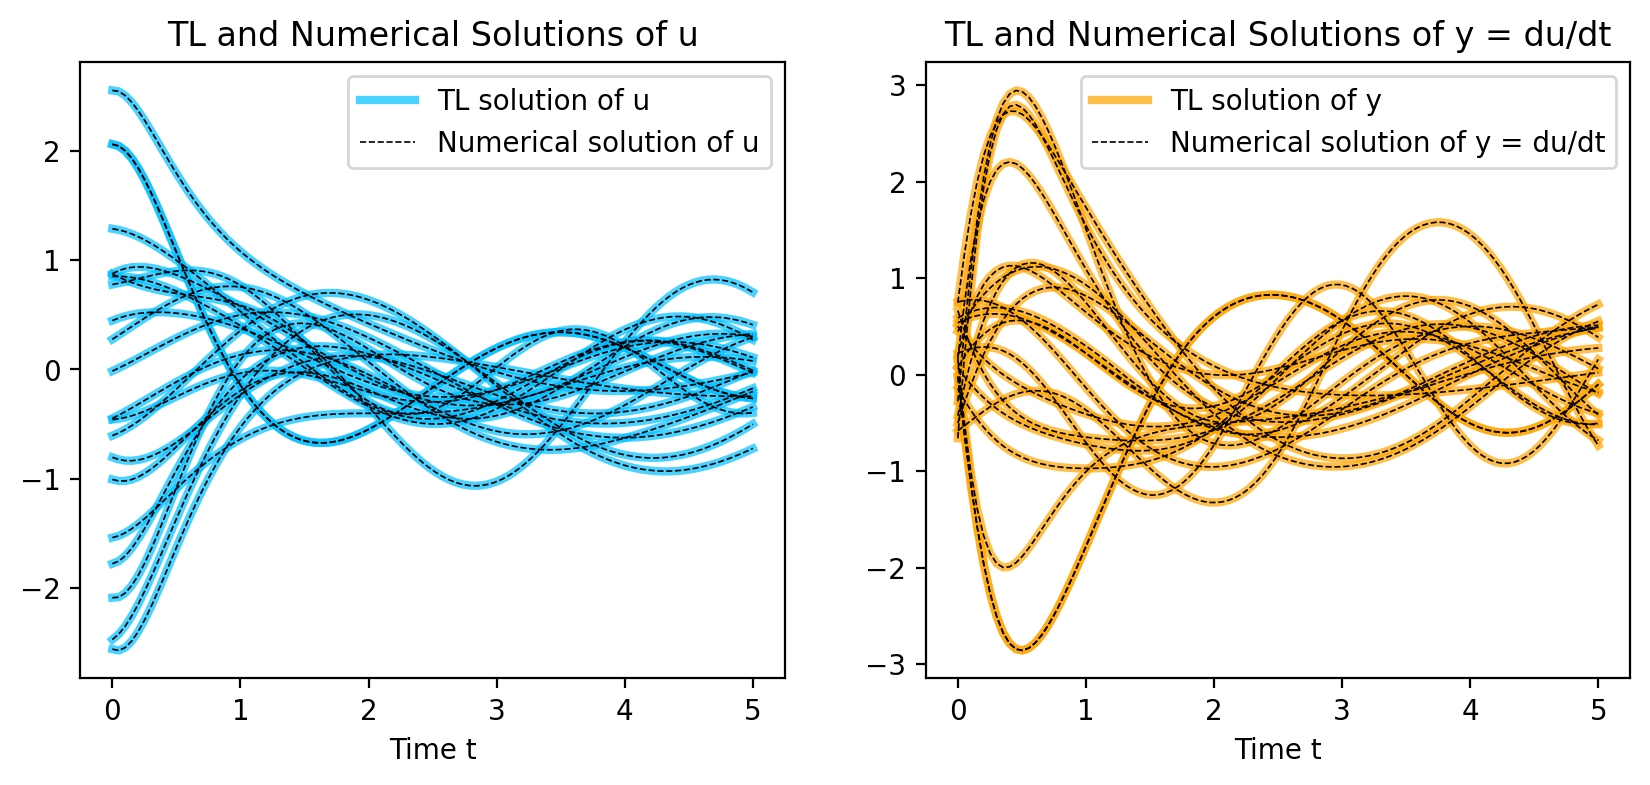

In [64]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), dpi=200);
for result in result_dict:
  ax[0].plot(t_points, result['x'], c='deepskyblue', lw=3, alpha=0.7);
  ax[1].plot(t_points, result['y'], c='orange', lw=3, alpha=0.7);
ax[0].plot(t_points, result_dict[-1]['x'], c='deepskyblue', lw=3, alpha=0.7, label='TL solution of u');
ax[1].plot(t_points, result_dict[-1]['y'], c='orange', lw=3, alpha=0.7, label='TL solution of y');
for result in numerical_duffings:
  ax[0].plot(result.t, result.y[0], '--', c='black', lw=0.6)
  ax[1].plot(result.t, result.y[1], '--', c='black', lw=0.6)
ax[0].plot(numerical_duffings[-1].t, numerical_duffings[-1].y[0], '--', c='black', lw=0.6, label='Numerical solution of u')
ax[1].plot(numerical_duffings[-1].t, numerical_duffings[-1].y[1], '--', c='black', lw=0.6, label='Numerical solution of y = du/dt')
ax[0].set_xlabel("Time t");
ax[1].set_xlabel("Time t");
ax[0].set_title("TL and Numerical Solutions of u");
ax[1].set_title("TL and Numerical Solutions of y = du/dt");
ax[0].legend(); ax[1].legend();

### Better Visulization for these 20 Solutions

In [66]:
TL_solutions = np.array([result['x'] for result in result_dict]) #shape (20, 100)
numerical_solutions = np.array([result.y[0] for result in numerical_duffings]) #shape (20, 100)

##compute the difference
diff_value = TL_solutions - numerical_solutions
mean_diff_value = diff_value.mean(axis=0)

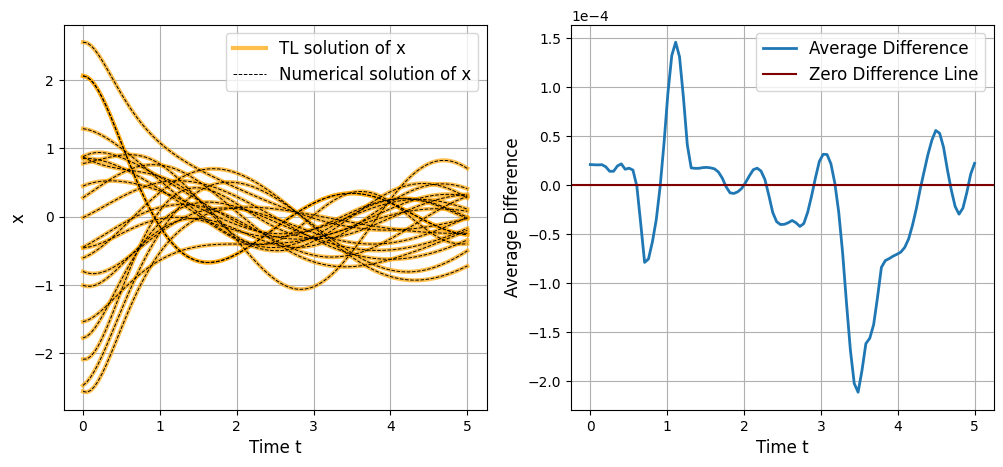

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for result in result_dict:
  ax[0].plot(t_points, result['x'], c='orange', lw=3, alpha=0.7);
ax[0].plot(t_points, result_dict[-1]['x'], c='orange', lw=3, alpha=0.7, label='TL solution of x');
for result in numerical_duffings:
  ax[0].plot(result.t, result.y[0], '--', c='black', lw=0.7)
ax[0].plot(numerical_duffings[-1].t, numerical_duffings[-1].y[0], '--', c='black', lw=0.7, label='Numerical solution of x')
ax[0].set_xlabel("Time t", fontsize=12);
ax[0].set_ylabel('x', fontsize=12)
ax[0].grid();
ax[0].legend(); ax[0].legend(fontsize=12);

ax[1].plot(t_points, mean_diff_value, lw=2, label='Average Difference');
ax[1].axhline(0, c='maroon', label='Zero Difference Line');
ax[1].set_xlabel("Time t", fontsize=12);
ax[1].grid();
ax[1].legend(); ax[1].legend(fontsize=12);
ax[1].set_ylabel('Average Difference', fontsize=12);
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('duffing_x.png', dpi=800)

In [68]:
duffing_MSE = ((np.array([dict['x'] for dict in result_dict]) - np.array([sol['y'][0] for sol in numerical_duffings]))**2).mean()
print("Average MSE between TL solution and numerical solution of Duffing: ", duffing_MSE)

Average MSE between TL solution and numerical solution of Duffing:  3.2651457274151884e-07


In [26]:
#fixing beta to 0.5
duffing_vs_p = []
for p in tqdm(range(1, 25)):
    beta = 0.5;
    indices_list = []
    for i in range(p):
        indices = find_three_integers(i)
        indices_list.append(indices)
        
    result_dict = []
    duffing_loss_list = []
    s = time.time()
    for i in range(num):
        f0_values = new_para['Forcing_functions'][i](t_grids).detach().numpy()
        dict = p_shot_solve(f0_values, beta, new_para['alpha_list'][i], new_para['delta_list'][i], 
                     new_para['initial_values'][i], new_para['initial_velocities'][i], H, Ht, H0, indices_list, p=p)
        result_dict.append(dict)
        duffing_dict = compute_duffing_loss(H, Ht, Htt, H0, dict['W'], new_para['delta_list'][i], 
                    new_para['alpha_list'][i], beta, f0_values, new_para['initial_values'][i], new_para['initial_velocities'][i])
        duffing_loss_list.append(duffing_dict)
    e = time.time()
    print("Speed: {} seconds per solve.".format((e-s)/num))
    mean_duffing_loss = np.mean([ele['total_loss'] for ele in duffing_loss_list])
    print(mean_duffing_loss)
    duffing_vs_p.append(mean_duffing_loss)

  0%|          | 0/24 [00:00<?, ?it/s]

Speed: 0.017067205905914307 seconds per solve.
0.41377875656748
Speed: 0.014385545253753662 seconds per solve.
0.20718380686826793
Speed: 0.013983607292175293 seconds per solve.
0.09937147567125863
Speed: 0.01522529125213623 seconds per solve.
0.04441148426986573
Speed: 0.017916250228881835 seconds per solve.
0.0185971911417619
Speed: 0.015306591987609863 seconds per solve.
0.007374627419310037
Speed: 0.014505302906036377 seconds per solve.
0.0027962675164732416
Speed: 0.014419293403625489 seconds per solve.
0.0010309383109531954
Speed: 0.014784550666809082 seconds per solve.
0.0003732139270712572
Speed: 0.01626570224761963 seconds per solve.
0.00013491085450716202
Speed: 0.014709246158599854 seconds per solve.
5.151895966920303e-05
Speed: 0.015223896503448487 seconds per solve.
1.9039639615163302e-05
Speed: 0.014895033836364747 seconds per solve.
8.584463007741243e-06
Speed: 0.01585046052932739 seconds per solve.
3.2673632416368076e-06
Speed: 0.015369200706481933 seconds per solve.
2.

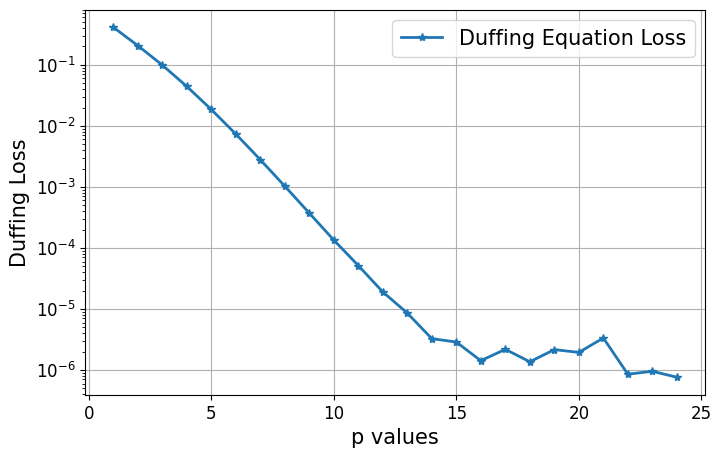

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 25), duffing_vs_p, '*-', label='Duffing Equation Loss', lw=2);
plt.yscale('log');
plt.grid();
plt.xlabel('p values', fontsize=15);
plt.ylabel("Duffing Loss", fontsize=15);
plt.legend(fontsize=15);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('duffing_loss_vs_p.png', dpi=500);

### Now Let's See the Influence of the Number of Heads
Train Networks of Heads 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15.

In [120]:
model_list = []; loss_trace_list = []
random_seed = 42
PARA_DICT = generate_parameters(10, seed=random_seed)

for k in range(1, 11):
    print('Network with {} heads'.format(k))
    model = Multihead(k=k, act = nn.functional.silu)
    para_dict = {key: PARA_DICT[key][:k] for key in PARA_DICT.keys()}
    #weights
    alpha_ode = 0.5; alpha_ic = 1.5
    
    ##define the optimizer
    learning_rate = 4e-4
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    ##define the exponential learning rate decay scheduler
    gamma = 0.92; step_size = 100
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    ##define number of iterations to take
    num_iter = 4000
    every=100
    
    loss_trace, ode_loss_trace, ic_loss_trace = train(model, optimizer, loss, num_iter, para_dict, sample_size=sample_size, 
        domain=domain, every=every, ode_weight=alpha_ode, ic_weight=alpha_ic, 
        scheduler=scheduler, epsilon=epsilon, dtype=dtype, verbose=False)
    model_list.append(model)
    loss_trace_list.append(loss_trace)

Network with 1 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 2 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 3 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 4 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 5 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 6 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 7 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 8 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 9 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

Network with 10 heads


  0%|          | 0/4000 [00:00<?, ?it/s]

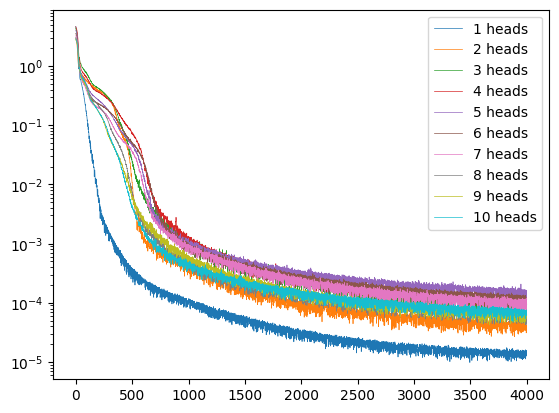

In [122]:
for i, trace in enumerate(loss_trace_list):
    plt.plot(trace, label='{} heads'.format(i+1), lw=.5)
    plt.yscale('log')
    plt.legend();

In [123]:
t_points = np.linspace(domain[0], domain[1], 100)
t_grids = torch.tensor(t_points, dtype=dtype).reshape(-1, 1)
t_grids.requires_grad_()
models_MSE_list = []
models_duffing_list = []

for model in tqdm(model_list):
    ##compute H and Ht
    output, H = model(t_grids) #shape (k, 50, 2)
    
    Ht = compute_Ht(H, t_grids) #numpy of shape (N, 512)
    Htt = compute_Htt(H, t_grids)
    ##reshape Ht to shape (2N, 257) add column of 0
    Ht = np.hstack((Ht.reshape(2*Ht.shape[0], -1), np.zeros((2*Ht.shape[0], 1))))
    Htt = np.hstack((Htt.reshape(2*Htt.shape[0], -1), np.zeros((2*Htt.shape[0], 1))))
    
    ##reshape H into a numpy array of shape (2N, 257) add column of 1
    H = H.detach().numpy()
    H = np.hstack((H.reshape(2*H.shape[0], -1), np.ones((2*H.shape[0], 1))))
    
    #compute H0
    _, H0 = model(torch.tensor([[0]], dtype=dtype))
    H0 = np.hstack([H0.reshape(2, -1).detach().numpy(), np.ones((2*H0.shape[0], 1))]) #shape (2, 257)

    #fixing beta to 0.5
    beta = 0.5; p = 21
    indices_list = []
    for i in range(p):
        indices = find_three_integers(i)
        indices_list.append(indices)
        
    result_dict = []
    duffing_loss_list = []
    s = time.time()
    for i in tqdm(range(num)):
        f0_values = new_para['Forcing_functions'][i](t_grids).detach().numpy()
        dict = p_shot_solve(f0_values, beta, new_para['alpha_list'][i], new_para['delta_list'][i], 
                     new_para['initial_values'][i], new_para['initial_velocities'][i], H, Ht, H0, indices_list, p=p)
        result_dict.append(dict)
        duffing_dict = compute_duffing_loss(H, Ht, Htt, H0, dict['W'], new_para['delta_list'][i], 
                    new_para['alpha_list'][i], beta, f0_values, new_para['initial_values'][i], new_para['initial_velocities'][i])
        duffing_loss_list.append(duffing_dict)
    e = time.time()
    print("Speed: {} seconds per solve.".format((e-s)/num))
    mean_duffing_loss = np.mean([ele['total_loss'] for ele in duffing_loss_list])
    print(mean_duffing_loss)

    duffing_MSE = ((np.array([dict['x'] for dict in result_dict]) - np.array([sol['y'][0] for sol in numerical_duffings]))**2).mean()
    print("Average MSE between TL solution and numerical solution of Duffing: ", duffing_MSE)

    models_MSE_list.append(duffing_MSE)
    models_duffing_list.append(mean_duffing_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.017899107933044434 seconds per solve.
0.0011472824116101298
Average MSE between TL solution and numerical solution of Duffing:  8.330319161552824e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.01882514953613281 seconds per solve.
1.1290089897197514e-06
Average MSE between TL solution and numerical solution of Duffing:  1.0694636591578089e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.024549293518066406 seconds per solve.
1.130331869281669e-06
Average MSE between TL solution and numerical solution of Duffing:  1.2482884550017378e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.024576997756958006 seconds per solve.
1.4298080385280952e-06
Average MSE between TL solution and numerical solution of Duffing:  1.139666053614693e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.029850566387176515 seconds per solve.
3.5042351581732903e-06
Average MSE between TL solution and numerical solution of Duffing:  2.3564747632932273e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.01808880567550659 seconds per solve.
4.0260411469579875e-06
Average MSE between TL solution and numerical solution of Duffing:  2.469329175665202e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.017836594581604005 seconds per solve.
8.21261333590962e-07
Average MSE between TL solution and numerical solution of Duffing:  9.849216772848341e-08


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.01971285343170166 seconds per solve.
1.6962105902798242e-06
Average MSE between TL solution and numerical solution of Duffing:  1.589127877755388e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.026306653022766115 seconds per solve.
1.4194472876909276e-06
Average MSE between TL solution and numerical solution of Duffing:  1.3043619467881467e-07


  0%|          | 0/20 [00:00<?, ?it/s]

Speed: 0.018806099891662598 seconds per solve.
3.047329365735345e-06
Average MSE between TL solution and numerical solution of Duffing:  2.0468162970622982e-07


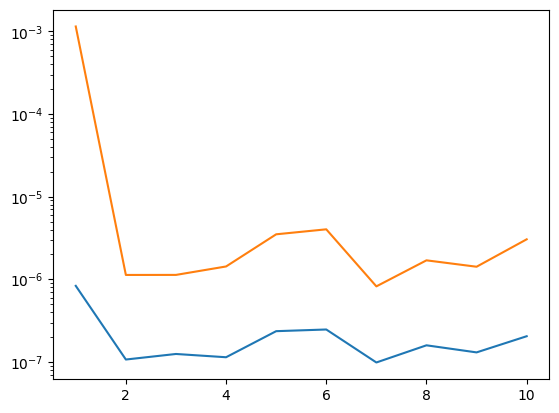

In [124]:
plt.plot(range(1, 11), models_MSE_list);
plt.plot(range(1, 11), models_duffing_list)
plt.yscale('log');

In [117]:
#this code is just for precomputing the hidden state H and its derivative 
##compute H and Ht
t_points = np.linspace(domain[0], domain[1], 100)
t_grids = torch.tensor(t_points, dtype=dtype).reshape(-1, 1)
t_grids.requires_grad_()
output, H = model_list[0](t_grids) #shape (k, 50, 2)

Ht = compute_Ht(H, t_grids) #numpy of shape (N, 512)
Htt = compute_Htt(H, t_grids)
##reshape Ht to shape (2N, 257) add column of 0
Ht = np.hstack((Ht.reshape(2*Ht.shape[0], -1), np.zeros((2*Ht.shape[0], 1))))
Htt = np.hstack((Htt.reshape(2*Htt.shape[0], -1), np.zeros((2*Htt.shape[0], 1))))

##reshape H into a numpy array of shape (2N, 257) add column of 1
H = H.detach().numpy()
H = np.hstack((H.reshape(2*H.shape[0], -1), np.ones((2*H.shape[0], 1))))

#compute H0
_, H0 = model_list[0](torch.tensor([[0]], dtype=dtype))
H0 = np.hstack([H0.reshape(2, -1).detach().numpy(), np.ones((2*H0.shape[0], 1))]) #shape (2, 257)

In [118]:
TL_sol = []; numerical_sol = []
##TL solve
s = time.time()
for i in tqdm(range(num)):
  #initial position and velocity
  initial_value = new_para['initial_values'][i]; initial_velocity = new_para['initial_velocities'][i]
  alpha = new_para['alpha_list'][i]; delta= new_para['delta_list'][i]
  #define new forcing functions
  f = new_para['Forcing_functions'][i]
  result = One_Shot_solve(f, H, Ht, H0, alpha, delta, initial_value, initial_velocity, t_grids)
  TL_sol.append(result)
e = time.time()
print("One-Shot TL takes about {} seconds per solve".format((e-s)/num))

#numerical solve
s = time.time()
for i in tqdm(range(num)):
  #initial position and velocity
  initial_value = new_para['initial_values'][i]; initial_velocity = new_para['initial_velocities'][i]
  alpha = new_para['alpha_list'][i]; delta= new_para['delta_list'][i]
  gamma = new_para['gamma_list'][i]; omega = new_para['omega_list'][i]
  numerical_result = solve_ivp(RHS_decorator(gamma, omega, alpha, delta), domain, np.array([initial_value, initial_velocity]),
                             t_eval=np.linspace(0, 5, 100), method = 'DOP853')
  numerical_sol.append(numerical_result)
e = time.time()
print("Numerical Method takes about {} seconds per solve".format((e-s)/num))

  0%|          | 0/20 [00:00<?, ?it/s]

One-Shot TL takes about 0.022246801853179933 seconds per solve


  0%|          | 0/20 [00:00<?, ?it/s]

Numerical Method takes about 0.002215445041656494 seconds per solve


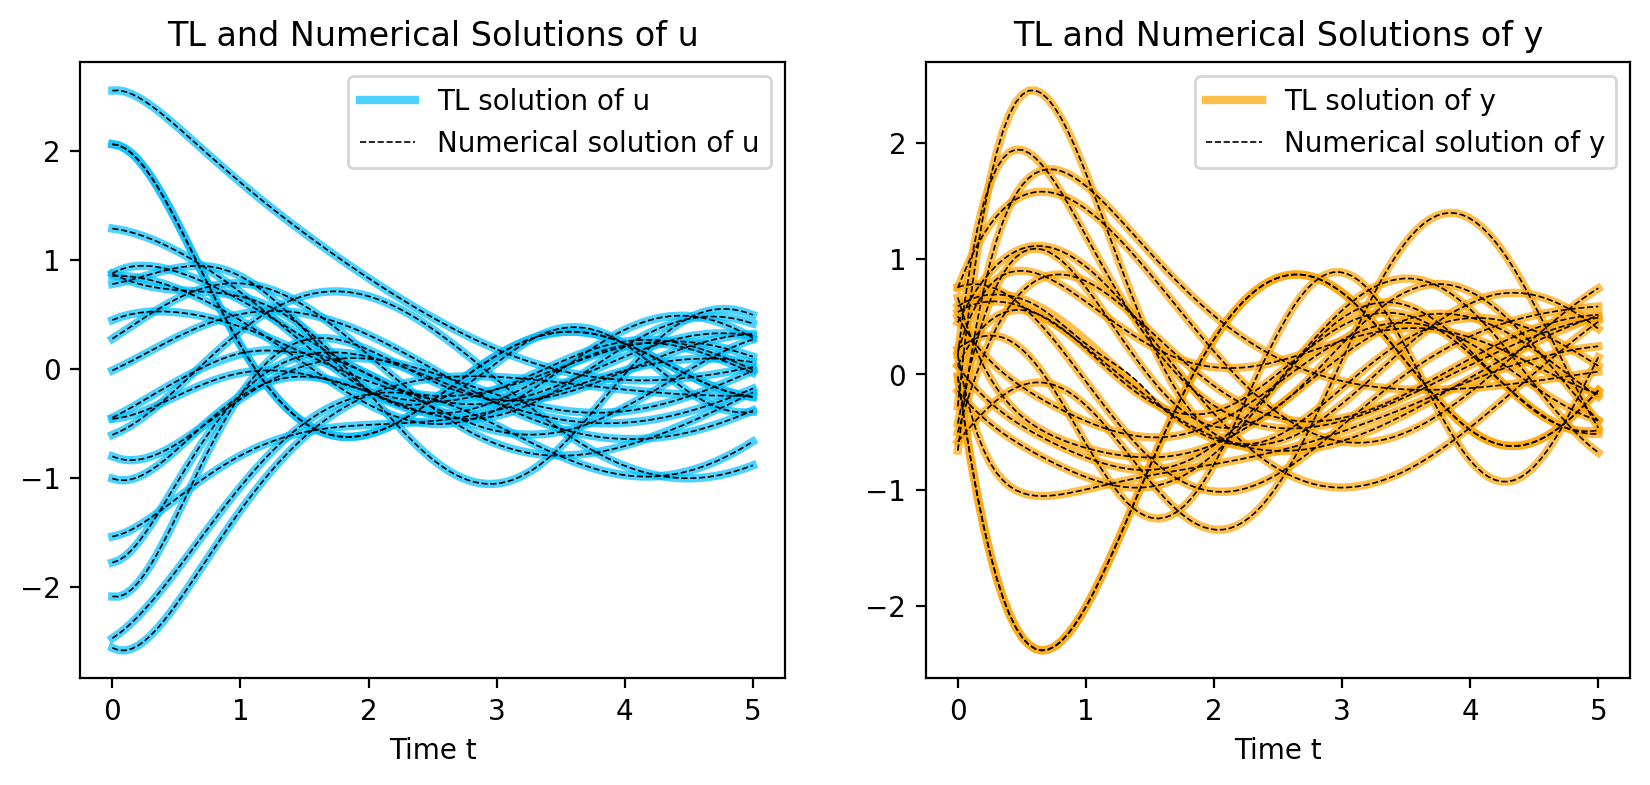

In [119]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), dpi=200);
for result in TL_sol:
  ax[0].plot(t_points, result['x'], c='deepskyblue', lw=3, alpha=0.7);
  ax[1].plot(t_points, result['y'], c='orange', lw=3, alpha=0.7);
ax[0].plot(t_points, TL_sol[-1]['x'], c='deepskyblue', lw=3, alpha=0.7, label='TL solution of u');
ax[1].plot(t_points, TL_sol[-1]['y'], c='orange', lw=3, alpha=0.7, label='TL solution of y');
for result in numerical_sol:
  ax[0].plot(result.t, result.y[0], '--', c='black', lw=0.6)
  ax[1].plot(result.t, result.y[1], '--', c='black', lw=0.6)
ax[0].plot(numerical_sol[-1].t, numerical_sol[-1].y[0], '--', c='black', lw=0.6, label='Numerical solution of u')
ax[1].plot(numerical_sol[-1].t, numerical_sol[-1].y[1], '--', c='black', lw=0.6, label='Numerical solution of y')
ax[0].set_xlabel("Time t");
ax[1].set_xlabel("Time t");
ax[0].set_title("TL and Numerical Solutions of u");
ax[1].set_title("TL and Numerical Solutions of y");
ax[0].legend(); ax[1].legend();